In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import QuantLib as ql
import mibian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from copy import deepcopy
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, DenseConv1D, MaxPooling1D, LSTM, Bidirectional, GRU, Flatten, Dense, TimeDistributed, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from ta import add_all_ta_features
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from tensorflow import keras
from math import sqrt
keras.utils.set_random_seed(812)
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasRegressor

# Data Preprocessing

In [16]:
# Read the data
df = pd.read_csv('data.csv')

# TSLA data Preprocessing

In [17]:
df_TSLA = df[df['Stock_TSLA'] == 1.0]

# Calculate Simple Moving Average
df_TSLA['SMA'] = df_TSLA['UNDERLYING_LAST'].rolling(window=14).mean()

# Calculate Exponential Moving Average
df_TSLA['EMA'] = df_TSLA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()

# Calculate RSI
df_TSLA['RSI'] = RSIIndicator(close=df_TSLA['UNDERLYING_LAST'], window=14).rsi()

# Calculate Bollinger Bands
indicator_bb = BollingerBands(close=df_TSLA['UNDERLYING_LAST'], window=20, window_dev=2)
df_TSLA['bb_bbm'] = indicator_bb.bollinger_mavg()
df_TSLA['bb_bbh'] = indicator_bb.bollinger_hband()
df_TSLA['bb_bbl'] = indicator_bb.bollinger_lband()

# Realized Volatility
df_TSLA['realized_vol'] = df_TSLA['UNDERLYING_LAST'].pct_change().rolling(window=14).std() * np.sqrt(252)


# For lagged features of the target variable, C_LAST:
df_TSLA['C_LAST_lag1'] = df_TSLA['C_LAST'].shift(1)
# For other variables, you could do the same:
df_TSLA['C_IV_lag1'] = df_TSLA['C_IV'].shift(1)


df_TSLA = df_TSLA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate', 'dividend_rate','C_LAST']]
df_TSLA = df_TSLA.dropna()

# Find indices where C_IV or DTE is zero
indices_to_remove = df_TSLA[(df_TSLA['C_IV'] == 0) | (df_TSLA['DTE'] == 0)].index

# Drop these indices from the DataFrame
df_TSLA = df_TSLA.drop(indices_to_remove)

# Reset the index
df_TSLA = df_TSLA.reset_index(drop=True)

/var/folders/j4/4m0tbkvs42v3qk8nmtg75bkm0000gn/T/ipykernel_37918/2518326361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TSLA['SMA'] = df_TSLA['UNDERLYING_LAST'].rolling(window=14).mean()
/var/folders/j4/4m0tbkvs42v3qk8nmtg75bkm0000gn/T/ipykernel_37918/2518326361.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TSLA['EMA'] = df_TSLA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()
/var/folders/j4/4m0tbkvs42v3qk8nmtg75bkm0000gn/T/ipykernel_37918/2518326361.py:10: SettingWithCopyWarning: 


# AAPL data Preprocessing

In [225]:
df_AAPL = df[df['Stock_AAPL'] == 1.0]

# Calculate Simple Moving Average
df_AAPL['SMA'] = df_AAPL['UNDERLYING_LAST'].rolling(window=14).mean()

# Calculate Exponential Moving Average
df_AAPL['EMA'] = df_AAPL['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()

# Calculate RSI
df_AAPL['RSI'] = RSIIndicator(close=df_AAPL['UNDERLYING_LAST'], window=14).rsi()

# Calculate Bollinger Bands
indicator_bb = BollingerBands(close=df_AAPL['UNDERLYING_LAST'], window=20, window_dev=2)
df_AAPL['bb_bbm'] = indicator_bb.bollinger_mavg()
df_AAPL['bb_bbh'] = indicator_bb.bollinger_hband()
df_AAPL['bb_bbl'] = indicator_bb.bollinger_lband()

# Realized Volatility
df_AAPL['realized_vol'] = df_AAPL['UNDERLYING_LAST'].pct_change().rolling(window=14).std() * np.sqrt(252)


# For lagged features of the target variable, C_LAST:
df_AAPL['C_LAST_lag1'] = df_AAPL['C_LAST'].shift(1)
# For other variables, you could do the same:
df_AAPL['C_IV_lag1'] = df_AAPL['C_IV'].shift(1)


df_AAPL = df_AAPL[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate', 'C_LAST']]
df_AAPL = df_AAPL.dropna()

# Find indices where C_IV or DTE is zero
indices_to_remove = df_AAPL[(df_AAPL['C_IV'] == 0) | (df_AAPL['DTE'] == 0)].index

# Drop these indices from the DataFrame
df_AAPL = df_AAPL.drop(indices_to_remove)

# Reset the index
df_AAPL = df_AAPL.reset_index(drop=True)

/var/folders/j4/4m0tbkvs42v3qk8nmtg75bkm0000gn/T/ipykernel_37918/2192086726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AAPL['SMA'] = df_AAPL['UNDERLYING_LAST'].rolling(window=14).mean()
/var/folders/j4/4m0tbkvs42v3qk8nmtg75bkm0000gn/T/ipykernel_37918/2192086726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AAPL['EMA'] = df_AAPL['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()
/var/folders/j4/4m0tbkvs42v3qk8nmtg75bkm0000gn/T/ipykernel_37918/2192086726.py:10: SettingWithCopyWarning: 


# NVDA data Preprocessing

In [226]:
df_NVDA = df[df['Stock_NVDA'] == 1.0]

# Calculate Simple Moving Average
df_NVDA['SMA'] = df_NVDA['UNDERLYING_LAST'].rolling(window=14).mean()

# Calculate Exponential Moving Average
df_NVDA['EMA'] = df_NVDA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()

# Calculate RSI
df_NVDA['RSI'] = RSIIndicator(close=df_NVDA['UNDERLYING_LAST'], window=14).rsi()

# Calculate Bollinger Bands
indicator_bb = BollingerBands(close=df_NVDA['UNDERLYING_LAST'], window=20, window_dev=2)
df_NVDA['bb_bbm'] = indicator_bb.bollinger_mavg()
df_NVDA['bb_bbh'] = indicator_bb.bollinger_hband()
df_NVDA['bb_bbl'] = indicator_bb.bollinger_lband()

# Realized Volatility
df_NVDA['realized_vol'] = df_NVDA['UNDERLYING_LAST'].pct_change().rolling(window=14).std() * np.sqrt(252)


# For lagged features of the target variable, C_LAST:
df_NVDA['C_LAST_lag1'] = df_NVDA['C_LAST'].shift(1)
# For other variables, you could do the same:
df_NVDA['C_IV_lag1'] = df_NVDA['C_IV'].shift(1)


df_NVDA = df_NVDA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate', 'C_LAST']]
df_NVDA = df_NVDA.dropna()

# Find indices where C_IV or DTE is zero
indices_to_remove = df_NVDA[(df_NVDA['C_IV'] == 0) | (df_NVDA['DTE'] == 0)].index

# Drop these indices from the DataFrame
df_NVDA = df_NVDA.drop(indices_to_remove)

# Reset the index
df_NVDA = df_NVDA.reset_index(drop=True)

/var/folders/j4/4m0tbkvs42v3qk8nmtg75bkm0000gn/T/ipykernel_37918/1211373322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA['SMA'] = df_NVDA['UNDERLYING_LAST'].rolling(window=14).mean()
/var/folders/j4/4m0tbkvs42v3qk8nmtg75bkm0000gn/T/ipykernel_37918/1211373322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NVDA['EMA'] = df_NVDA['UNDERLYING_LAST'].ewm(span=14, adjust=False).mean()
/var/folders/j4/4m0tbkvs42v3qk8nmtg75bkm0000gn/T/ipykernel_37918/1211373322.py:10: SettingWithCopyWarning: 


# Features

In [18]:
# Prepare the features and target variable
X_TSLA = df_TSLA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST',  'STRIKE','DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate']].values
y_TSLA = df_TSLA['C_LAST'].values

In [228]:
# Prepare the features and target variable
X_NVDA = df_NVDA[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST',  'STRIKE','DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate']].values
y_NVDA = df_NVDA['C_LAST'].values

In [229]:
# Prepare the features and target variable
X_AAPL = df_AAPL[['C_IV_lag1','C_LAST_lag1','bb_bbm','bb_bbh','bb_bbl','SMA','EMA','RSI', 'realized_vol','UNDERLYING_LAST',  'STRIKE','DTE', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'interest rate','dividend_rate']].values
y_AAPL = df_AAPL['C_LAST'].values

# Train, Validation and Test Set Preparation

In [19]:
# Define split points
train_split_TSLA = int(len(X_TSLA) * 0.7)  # 70% of the data for training
val_split_TSLA = int(len(X_TSLA) * 0.8)    

# Split the data into training, validation, and testing sets
X_train_TSLA, X_val_test_TSLA = X_TSLA[:train_split_TSLA], X_TSLA[train_split_TSLA:]
y_train_TSLA, y_val_test_TSLA = y_TSLA[:train_split_TSLA], y_TSLA[train_split_TSLA:]

# Split the remaining 30% into validation and test sets
val_size_TSLA = int(len(X_val_test_TSLA) * (10/30))  
X_val_TSLA, X_test_TSLA = X_val_test_TSLA[:val_size_TSLA], X_val_test_TSLA[val_size_TSLA:]
y_val_TSLA, y_test_TSLA = y_val_test_TSLA[:val_size_TSLA], y_val_test_TSLA[val_size_TSLA:]

In [230]:
# Define split points
train_split_AAPL = int(len(X_AAPL) * 0.7)  # 70% of the data for training
val_split_AAPL = int(len(X_AAPL) * 0.8)    

# Split the data into training, validation, and testing sets
X_train_AAPL, X_val_test_AAPL = X_AAPL[:train_split_AAPL], X_AAPL[train_split_AAPL:]
y_train_AAPL, y_val_test_AAPL = y_AAPL[:train_split_AAPL], y_AAPL[train_split_AAPL:]

# Split the remaining 30% into validation and test sets
val_size_AAPL = int(len(X_val_test_AAPL) * (10/30))  
X_val_AAPL, X_test_AAPL = X_val_test_AAPL[:val_size_AAPL], X_val_test_AAPL[val_size_AAPL:]
y_val_AAPL, y_test_AAPL = y_val_test_AAPL[:val_size_AAPL], y_val_test_AAPL[val_size_AAPL:]

In [231]:
# Define split points for NVDA dataset
train_split_NVDA = int(len(X_NVDA) * 0.7)  # 70% of the data for training
val_split_NVDA = int(len(X_NVDA) * 0.8)    

# Split the data into training, validation, and testing sets
X_train_NVDA, X_val_test_NVDA = X_NVDA[:train_split_NVDA], X_NVDA[train_split_NVDA:]
y_train_NVDA, y_val_test_NVDA = y_NVDA[:train_split_NVDA], y_NVDA[train_split_NVDA:]

# Split the remaining 30% into validation and test sets
val_size_NVDA = int(len(X_val_test_NVDA) * (10/30))  
X_val_NVDA, X_test_NVDA = X_val_test_NVDA[:val_size_NVDA], X_val_test_NVDA[val_size_NVDA:]
y_val_NVDA, y_test_NVDA = y_val_test_NVDA[:val_size_NVDA], y_val_test_NVDA[val_size_NVDA:]

# Data Preparation for RNN (LSTM, GRU, BiLSTM)

In [20]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_TSLA)
X_val_scaled = scaler.transform(X_val_TSLA)
X_test_scaled = scaler.transform(X_test_TSLA)

# Reshape input to be [samples, time steps, features] which is required for LSTM, BiLSTM, and GRU
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [239]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_AAPL = scaler.fit_transform(X_train_AAPL)
X_val_scaled_AAPL = scaler.transform(X_val_AAPL)
X_test_scaled_AAPL = scaler.transform(X_test_AAPL)

# Reshape input to be [samples, time steps, features] which is required for LSTM, BiLSTM, and GRU
X_train_scaled_AAPL = X_train_scaled_AAPL.reshape((X_train_scaled_AAPL.shape[0], 1, X_train_scaled_AAPL.shape[1]))
X_val_scaled_AAPL = X_val_scaled_AAPL.reshape((X_val_scaled_AAPL.shape[0], 1, X_val_scaled_AAPL.shape[1]))
X_test_scaled_AAPL = X_test_scaled_AAPL.reshape((X_test_scaled_AAPL.shape[0], 1, X_test_scaled_AAPL.shape[1]))

In [240]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_NVDA = scaler.fit_transform(X_train_NVDA)
X_val_scaled_NVDA = scaler.transform(X_val_NVDA)
X_test_scaled_NVDA = scaler.transform(X_test_NVDA)

# Reshape input to be [samples, time steps, features] which is required for LSTM, BiLSTM, and GRU
X_train_scaled_NVDA = X_train_scaled_NVDA.reshape((X_train_scaled_NVDA.shape[0], 1, X_train_scaled_NVDA.shape[1]))
X_val_scaled_NVDA = X_val_scaled_NVDA.reshape((X_val_scaled_NVDA.shape[0], 1, X_val_scaled_NVDA.shape[1]))
X_test_scaled_NVDA = X_test_scaled_NVDA.reshape((X_test_scaled_NVDA.shape[0], 1, X_test_scaled_NVDA.shape[1]))

# Early Stopping 

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Basic LSTM

In [21]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
lstm_model.add(Dense(1))

# Compile the models
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
# Define callbacks
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit the LSTM model
history_lstm = lstm_model.fit(
    X_train_scaled, y_train_TSLA, 
    epochs=100,  
    batch_size=32, 
    validation_data=(X_val_scaled, y_val_TSLA), 
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/100
7526/7526 [==============================] - 47s 6ms/step - loss: 135.7168 - val_loss: 301.9375
Epoch 2/100
7526/7526 [==============================] - 46s 6ms/step - loss: 113.5806 - val_loss: 242.3206
Epoch 3/100
7526/7526 [==============================] - 48s 6ms/step - loss: 109.4850 - val_loss: 237.0301
Epoch 4/100
7526/7526 [==============================] - 46s 6ms/step - loss: 107.5144 - val_loss: 242.1085
Epoch 5/100
7526/7526 [==============================] - 42s 6ms/step - loss: 106.2654 - val_loss: 228.4237
Epoch 6/100
7526/7526 [==============================] - 44s 6ms/step - loss: 105.3563 - val_loss: 240.6444
Epoch 7/100
7526/7526 [==============================] - 41s 5ms/step - loss: 104.6582 - val_loss: 226.1394
Epoch 8/100
7526/7526 [==============================] - 40s 5ms/step - loss: 104.0904 - val_loss: 234.1150
Epoch 9/100
7526/7526 [==============================] - 46s 6ms/step - loss: 103.3623 - val_loss: 208.3266
Epoch 10/100
7526/7526 [====

In [27]:
y_pred_lstm = lstm_model.predict(X_test_scaled)
rmse_lstm = sqrt(mean_squared_error(y_test_TSLA, y_pred_lstm))
print(f"LSTM RMSE: {rmse_lstm}")

2151/2151 [==============================] - 3s 2ms/step
LSTM RMSE: 13.736701255401467


# Basic Bidirectional LSTM

In [28]:
# Define the Bidirectional LSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(50), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
# Fit the Bidirectional LSTM model
history_bilstm = bilstm_model.fit(
    X_train_scaled, y_train_TSLA, 
    epochs=100,
    batch_size=32, 
    validation_data=(X_val_scaled, y_val_TSLA), 
    callbacks=[early_stopping, ModelCheckpoint('best_bilstm_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

Epoch 1/100
7526/7526 [==============================] - 28s 3ms/step - loss: 498.2319 - val_loss: 332.7070
Epoch 2/100
7526/7526 [==============================] - 25s 3ms/step - loss: 117.4691 - val_loss: 241.0544
Epoch 3/100
7526/7526 [==============================] - 25s 3ms/step - loss: 111.0862 - val_loss: 231.2294
Epoch 4/100
7526/7526 [==============================] - 25s 3ms/step - loss: 108.7417 - val_loss: 242.1611
Epoch 5/100
7526/7526 [==============================] - 25s 3ms/step - loss: 107.2034 - val_loss: 230.2796
Epoch 6/100
7526/7526 [==============================] - 25s 3ms/step - loss: 106.0757 - val_loss: 238.9632
Epoch 7/100
7526/7526 [==============================] - 26s 3ms/step - loss: 105.1821 - val_loss: 223.2638
Epoch 8/100
7526/7526 [==============================] - 26s 3ms/step - loss: 104.3703 - val_loss: 234.2121
Epoch 9/100
7526/7526 [==============================] - 25s 3ms/step - loss: 103.3692 - val_loss: 207.7466
Epoch 10/100
7526/7526 [====

In [88]:
y_pred_bilstm = bilstm_model.predict(X_test_scaled)
rmse_bilstm = sqrt(mean_squared_error(y_test_TSLA, y_pred_bilstm))
print(f"BiLSTM RMSE: {rmse_bilstm}")

2151/2151 [==============================] - 4s 2ms/step
BiLSTM RMSE: 14.13270566401358


# Basic GRU

In [31]:
# Define the GRU model
gru_model = Sequential()
gru_model.add(GRU(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
# Fit the GRU model
history_gru = gru_model.fit(
    X_train_scaled, y_train_TSLA, 
    epochs=100,
    batch_size=32, 
    validation_data=(X_val_scaled, y_val_TSLA), 
    callbacks=[early_stopping, ModelCheckpoint('best_gru_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

Epoch 1/100
7526/7526 [==============================] - 22s 3ms/step - loss: 657.1649 - val_loss: 432.3018
Epoch 2/100
7526/7526 [==============================] - 19s 3ms/step - loss: 120.8293 - val_loss: 253.8939
Epoch 3/100
7526/7526 [==============================] - 20s 3ms/step - loss: 110.8535 - val_loss: 236.8273
Epoch 4/100
7526/7526 [==============================] - 21s 3ms/step - loss: 108.3470 - val_loss: 241.1028
Epoch 5/100
7526/7526 [==============================] - 20s 3ms/step - loss: 106.8766 - val_loss: 231.4398
Epoch 6/100
7526/7526 [==============================] - 20s 3ms/step - loss: 105.9097 - val_loss: 240.4187
Epoch 7/100
7526/7526 [==============================] - 20s 3ms/step - loss: 105.2632 - val_loss: 226.1478
Epoch 8/100
7526/7526 [==============================] - 20s 3ms/step - loss: 104.8292 - val_loss: 232.9587
Epoch 9/100
7526/7526 [==============================] - 20s 3ms/step - loss: 104.2549 - val_loss: 208.6066
Epoch 10/100
7526/7526 [====

In [162]:
y_pred_gru= gru_model.predict(X_test_scaled)
rmse_gru= sqrt(mean_squared_error(y_test_TSLA, y_pred_gru))
print(f"GRU RMSE: {rmse_gru}")

2151/2151 [==============================] - 3s 1ms/step
GRU RMSE: 13.640402938930471


# Best Model is GRU, followed by LSTM, and lastly BiLSTM, hence, we will be adding complexity to only the GRU and LSTM models from here on

# 2-layer Stacked LSTM

In [185]:
# Define a stacked LSTM model
def create_stacked_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Assuming input_shape has been defined based on your scaled training data
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model_stacked_lstm = create_stacked_lstm(input_shape)

In [186]:
history_stacked_lstm = model_stacked_lstm.fit(
    X_train_scaled, y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_scaled, y_val_TSLA), 
    callbacks=[early_stopping, ModelCheckpoint('stacked_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

Epoch 1/100
7526/7526 [==============================] - 40s 5ms/step - loss: 745.6646 - val_loss: 552.1876
Epoch 2/100
7526/7526 [==============================] - 41s 5ms/step - loss: 117.1720 - val_loss: 248.6272
Epoch 3/100
7526/7526 [==============================] - 38s 5ms/step - loss: 105.4512 - val_loss: 221.4416
Epoch 4/100
7526/7526 [==============================] - 44s 6ms/step - loss: 103.3983 - val_loss: 206.8194
Epoch 5/100
7526/7526 [==============================] - 49s 6ms/step - loss: 102.1340 - val_loss: 205.8976
Epoch 6/100
7526/7526 [==============================] - 46s 6ms/step - loss: 101.6044 - val_loss: 209.6232
Epoch 7/100
7526/7526 [==============================] - 44s 6ms/step - loss: 101.0211 - val_loss: 202.0710
Epoch 8/100
7526/7526 [==============================] - 44s 6ms/step - loss: 100.5718 - val_loss: 237.7401
Epoch 9/100
7526/7526 [==============================] - 48s 6ms/step - loss: 99.9452 - val_loss: 197.2397
Epoch 10/100
7526/7526 [=====

In [187]:
y_pred_stacked = model_stacked_lstm.predict(X_test_scaled)
rmse_stacked= sqrt(mean_squared_error(y_test_TSLA, y_pred_stacked))
print(f"2-layer Stacked LSTM RMSE: {rmse_stacked}")

2151/2151 [==============================] - 5s 2ms/step
2-layer Stacked LSTM RMSE: 13.118825825381789


# 2-layer (LSTM + GRU)

In [36]:
from tensorflow.keras.layers import GRU

# Define a model with LSTM and GRU layers combined
def create_lstm_gru(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_lstm_gru = create_lstm_gru(input_shape)

In [37]:
history_lstm_gru = model_lstm_gru.fit(
    X_train_scaled, y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_scaled, y_val_TSLA), 
    callbacks=[early_stopping, ModelCheckpoint('combined_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

Epoch 1/100
7526/7526 [==============================] - 34s 4ms/step - loss: 579.3480 - val_loss: 409.7470
Epoch 2/100
7526/7526 [==============================] - 29s 4ms/step - loss: 112.7790 - val_loss: 231.8331
Epoch 3/100
7526/7526 [==============================] - 30s 4ms/step - loss: 106.6923 - val_loss: 223.0611
Epoch 4/100
7526/7526 [==============================] - 30s 4ms/step - loss: 104.0022 - val_loss: 213.5750
Epoch 5/100
7526/7526 [==============================] - 30s 4ms/step - loss: 102.0931 - val_loss: 207.9829
Epoch 6/100
7526/7526 [==============================] - 30s 4ms/step - loss: 101.3019 - val_loss: 209.9110
Epoch 7/100
7526/7526 [==============================] - 30s 4ms/step - loss: 100.7126 - val_loss: 204.6729
Epoch 8/100
7526/7526 [==============================] - 30s 4ms/step - loss: 100.2245 - val_loss: 226.8449
Epoch 9/100
7526/7526 [==============================] - 30s 4ms/step - loss: 99.5614 - val_loss: 191.7734
Epoch 10/100
7526/7526 [=====

In [85]:
y_pred_combined = model_lstm_gru.predict(X_test_scaled)
rmse_combined= sqrt(mean_squared_error(y_test_TSLA, y_pred_combined))
print(f"LTSM + GRU RMSE: {rmse_combined}")

2151/2151 [==============================] - 3s 1ms/step
LTSM + GRU RMSE: 13.12142414509326


# 2-layer Stacked GRU

In [80]:
# Define a stacked GRU model
def create_stacked_gru(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model_stacked_gru = create_stacked_gru(input_shape)

In [81]:
history_lstm_gru = model_stacked_gru.fit(
    X_train_scaled, y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_scaled, y_val_TSLA), 
    callbacks=[early_stopping, ModelCheckpoint('stackedgru_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

Epoch 1/100
7526/7526 [==============================] - 42s 5ms/step - loss: 594.2678 - val_loss: 415.2550
Epoch 2/100
7526/7526 [==============================] - 43s 6ms/step - loss: 112.7414 - val_loss: 228.5597
Epoch 3/100
7526/7526 [==============================] - 46s 6ms/step - loss: 106.0785 - val_loss: 214.7909
Epoch 4/100
7526/7526 [==============================] - 47s 6ms/step - loss: 103.7874 - val_loss: 207.0939
Epoch 5/100
7526/7526 [==============================] - 47s 6ms/step - loss: 102.3247 - val_loss: 204.8532
Epoch 6/100
7526/7526 [==============================] - 42s 6ms/step - loss: 101.4719 - val_loss: 205.6804
Epoch 7/100
7526/7526 [==============================] - 41s 5ms/step - loss: 100.6173 - val_loss: 196.6072
Epoch 8/100
7526/7526 [==============================] - 41s 5ms/step - loss: 100.0034 - val_loss: 220.5123
Epoch 9/100
7526/7526 [==============================] - 45s 6ms/step - loss: 99.3094 - val_loss: 186.4050
Epoch 10/100
7526/7526 [=====

In [84]:
y_pred_stacked_gru = model_stacked_gru.predict(X_test_scaled)
rmse_stacked_gru= sqrt(mean_squared_error(y_test_TSLA, y_pred_stacked_gru))
print(f"2-layer Stacked GRU RMSE: {rmse_stacked_gru}")

2151/2151 [==============================] - 4s 2ms/step
Stacked GRU RMSE: 13.204850080105079


# GRU + LSTM is the best model

# 3 stacked LSTM

In [246]:
# Define a GRU + LSTM + LSTM
def create_stacked_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))  
    model.add(LSTM(50, return_sequences=True))  
    model.add(LSTM(50, return_sequences=False))  
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model_3stacked_lstm = create_stacked_lstm(input_shape)

In [ ]:
#ran already, kernel got restarted, rmse is as shown below
history_3stacked_lstm = model_3stacked_lstm.fit(
    X_train_scaled, y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_scaled, y_val_TSLA), 
    callbacks=[early_stopping, ModelCheckpoint('3stacked_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

In [256]:
print(f"Stacked LSTM RMSE: {rmse_3stacked}")

Stacked LSTM RMSE: 13.231426895850623


# Adding an additional layer does not improve RMSE, showing signs of overfitting

# CNN  

# Data Preparation for  CNN and CNN + 2-layer Stacked LSTM

In [54]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform training data
X_train_scale2 = scaler.fit_transform(X_train_TSLA)

# Transform validation and test data (do not fit the scaler on validation/test data to prevent data leakage)
X_val_scale2 = scaler.transform(X_val_TSLA)
X_test_scale2 = scaler.transform(X_test_TSLA)

# Reshape the data for CNN input (adding a 'time' dimension of 1)
X_train_cnn = X_train_scale2.reshape((X_train_scale2.shape[0], X_train_scale2.shape[1], 1))
X_val_cnn = X_val_scale2.reshape((X_val_scale2.shape[0], X_val_scale2.shape[1], 1))
X_test_cnn = X_test_scale2.reshape((X_test_scale2.shape[0], X_test_scale2.shape[1], 1))

# For CNN-LSTM, you would add an additional 'subsequence' dimension.
X_train_cnn_lstm = X_train_scale2.reshape((X_train_scale2.shape[0], 1, X_train_scale2.shape[1], 1))
X_val_cnn_lstm = X_val_scale2.reshape((X_val_scale2.shape[0], 1, X_val_scale2.shape[1], 1))
X_test_cnn_lstm = X_test_scale2.reshape((X_test_scale2.shape[0], 1, X_test_scale2.shape[1], 1))

# Simple CNN

In [135]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [137]:
# Train the model with early stopping
history = cnn_model.fit(
    X_train_cnn, 
    y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_cnn, y_val_TSLA),
    callbacks=[early_stopping, ModelCheckpoint('cnn_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)]
)

Epoch 1/100
7526/7526 [==============================] - 26s 3ms/step - loss: 103.0780 - val_loss: 211.5577
Epoch 2/100
7526/7526 [==============================] - 25s 3ms/step - loss: 102.6830 - val_loss: 201.9665
Epoch 3/100
7526/7526 [==============================] - 25s 3ms/step - loss: 102.1156 - val_loss: 182.6901
Epoch 4/100
7526/7526 [==============================] - 27s 4ms/step - loss: 101.9740 - val_loss: 205.7232
Epoch 5/100
7526/7526 [==============================] - 22s 3ms/step - loss: 101.6305 - val_loss: 185.7883
Epoch 6/100
7526/7526 [==============================] - 27s 4ms/step - loss: 101.3977 - val_loss: 191.4959
Epoch 7/100
7526/7526 [==============================] - 28s 4ms/step - loss: 101.5643 - val_loss: 174.4438
Epoch 8/100
7526/7526 [==============================] - 26s 3ms/step - loss: 101.2044 - val_loss: 210.1582
Epoch 9/100
7526/7526 [==============================] - 25s 3ms/step - loss: 100.6631 - val_loss: 189.1281
Epoch 10/100
7526/7526 [====

In [138]:
y_pred_cnn = cnn_model.predict(X_test_cnn)
rmse_cnn = sqrt(mean_squared_error(y_test_TSLA, y_pred_cnn))
print(f"CNN RMSE: {rmse_cnn}")

2151/2151 [==============================] - 4s 2ms/step
CNN RMSE: 13.798351558160618


# Complex CNN

In [180]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
complex_cnn_model = Sequential()

# First Convolutional Layer
complex_cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
complex_cnn_model.add(BatchNormalization())
complex_cnn_model.add(MaxPooling1D(pool_size=2))
complex_cnn_model.add(Dropout(0.2))

# Second Convolutional Layer
complex_cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
complex_cnn_model.add(BatchNormalization())
complex_cnn_model.add(MaxPooling1D(pool_size=2))
complex_cnn_model.add(Dropout(0.3))

# Flattening Layer
complex_cnn_model.add(Flatten())

# Dense Layers
complex_cnn_model.add(Dense(64, activation='relu'))
complex_cnn_model.add(Dropout(0.5))

# Output Layer
complex_cnn_model.add(Dense(1))

# Compile the model
complex_cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
complex_cnn_model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 21, 64)            256       
                                                                 
 batch_normalization_4 (Bat  (None, 21, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 10, 64)            0         
                                                                 
 conv1d_16 (Conv1D)          (None, 8, 128)            24704     
                                                                 
 batch_normalization_5 (Bat  (None, 8, 128)          

In [197]:
history = complex_cnn_model.fit(
    X_train_cnn, 
    y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_cnn, y_val_TSLA),
    callbacks=[early_stopping, ModelCheckpoint('complex_cnn_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)]
)

Epoch 1/100
7526/7526 [==============================] - 50s 7ms/step - loss: 217.7218 - val_loss: 309.9530
Epoch 2/100
7526/7526 [==============================] - 51s 7ms/step - loss: 212.6787 - val_loss: 324.5666
Epoch 3/100
7526/7526 [==============================] - 50s 7ms/step - loss: 208.0553 - val_loss: 220.0008
Epoch 4/100
7526/7526 [==============================] - 51s 7ms/step - loss: 204.0319 - val_loss: 300.1163
Epoch 5/100
7526/7526 [==============================] - 51s 7ms/step - loss: 198.1413 - val_loss: 287.2087
Epoch 6/100
7526/7526 [==============================] - 51s 7ms/step - loss: 200.5721 - val_loss: 341.4955
Epoch 7/100
7526/7526 [==============================] - 50s 7ms/step - loss: 196.3800 - val_loss: 307.7090
Epoch 8/100
7526/7526 [==============================] - 50s 7ms/step - loss: 191.5094 - val_loss: 334.1303
Epoch 9/100
7526/7526 [==============================] - 52s 7ms/step - loss: 191.7944 - val_loss: 305.1982
Epoch 10/100
7526/7526 [====

In [210]:
y_pred_complex_cnn = complex_cnn_model.predict(X_test_cnn)
rmse_complex_cnn = sqrt(mean_squared_error(y_test_TSLA, y_pred_complex_cnn))
print(f"Complex CNN RMSE: {rmse_complex_cnn}")

2151/2151 [==============================] - 5s 2ms/step
Complex CNN RMSE: 15.273652375925897


In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
complex_cnn_model2 = Sequential()

# First Convolutional Layer
complex_cnn_model2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
complex_cnn_model2.add(BatchNormalization())
complex_cnn_model2.add(MaxPooling1D(pool_size=2))
complex_cnn_model2.add(Dropout(0.2))

# Second Convolutional Layer
complex_cnn_model2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
complex_cnn_model2.add(BatchNormalization())
complex_cnn_model2.add(MaxPooling1D(pool_size=2))
complex_cnn_model2.add(Dropout(0.3))

# Third Convolutional Layer
complex_cnn_model2.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
complex_cnn_model2.add(BatchNormalization())
complex_cnn_model2.add(MaxPooling1D(pool_size=2))
complex_cnn_model2.add(Dropout(0.4))

# Flattening Layer
complex_cnn_model2.add(Flatten())

# Dense Layers
complex_cnn_model2.add(Dense(128, activation='relu'))
complex_cnn_model2.add(Dropout(0.5))
complex_cnn_model2.add(Dense(64, activation='relu'))
complex_cnn_model2.add(Dropout(0.5))

# Output Layer
complex_cnn_model2.add(Dense(1))

# Compile the model
complex_cnn_model2.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
complex_cnn_model2.summary()


Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 21, 64)            256       
                                                                 
 batch_normalization_6 (Bat  (None, 21, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 10, 64)            0         
                                                                 
 conv1d_18 (Conv1D)          (None, 8, 128)            24704     
                                                                 
 batch_normalization_7 (Bat  (None, 8, 128)          

In [199]:
history = complex_cnn_model2.fit(
    X_train_cnn, 
    y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_cnn, y_val_TSLA),
    callbacks=[early_stopping, ModelCheckpoint('complex_cnn_model2.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)]
)

Epoch 1/100
7526/7526 [==============================] - 78s 10ms/step - loss: 386.2731 - val_loss: 265.1779
Epoch 2/100
7526/7526 [==============================] - 77s 10ms/step - loss: 290.9915 - val_loss: 303.9330
Epoch 3/100
7526/7526 [==============================] - 76s 10ms/step - loss: 270.9557 - val_loss: 211.9121
Epoch 4/100
7526/7526 [==============================] - 77s 10ms/step - loss: 257.8607 - val_loss: 227.5210
Epoch 5/100
7526/7526 [==============================] - 76s 10ms/step - loss: 244.4459 - val_loss: 393.7065
Epoch 6/100
7526/7526 [==============================] - 76s 10ms/step - loss: 234.0663 - val_loss: 328.6454
Epoch 7/100
7526/7526 [==============================] - 77s 10ms/step - loss: 227.4417 - val_loss: 274.8105
Epoch 8/100
7526/7526 [==============================] - 76s 10ms/step - loss: 224.1438 - val_loss: 450.9078
Epoch 9/100
7526/7526 [==============================] - 77s 10ms/step - loss: 219.7783 - val_loss: 261.1671
Epoch 10/100
7526/7

In [211]:
y_pred_complex_cnn2 = complex_cnn_model2.predict(X_test_cnn)
rmse_complex_cnn2 = sqrt(mean_squared_error(y_test_TSLA, y_pred_complex_cnn2))
print(f"Complex CNN 2 RMSE: {rmse_complex_cnn2}")

2151/2151 [==============================] - 6s 3ms/step
Complex CNN 2 RMSE: 14.190275015837965


# CNN + Stacked LSTM 

In [139]:
cnn_stacked_lstm_model = Sequential()
cnn_stacked_lstm_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, X_train_cnn.shape[1], 1)))
cnn_stacked_lstm_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_stacked_lstm_model.add(TimeDistributed(Flatten()))
cnn_stacked_lstm_model.add(LSTM(50, return_sequences=True))
cnn_stacked_lstm_model.add(LSTM(50))
cnn_stacked_lstm_model.add(Dense(1))

cnn_stacked_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [140]:
# Train the model with early stopping
history_cnn_stacked_lstm = cnn_stacked_lstm_model.fit(
    X_train_cnn_lstm, 
    y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_cnn_lstm, y_val_TSLA),
    callbacks=[early_stopping]
)

Epoch 1/100
7526/7526 [==============================] - 80s 10ms/step - loss: 826.7011 - val_loss: 547.1683
Epoch 2/100
7526/7526 [==============================] - 79s 11ms/step - loss: 112.3893 - val_loss: 235.4584
Epoch 3/100
7526/7526 [==============================] - 83s 11ms/step - loss: 101.9090 - val_loss: 202.3958
Epoch 4/100
7526/7526 [==============================] - 85s 11ms/step - loss: 99.9412 - val_loss: 209.5016
Epoch 5/100
7526/7526 [==============================] - 89s 12ms/step - loss: 98.9597 - val_loss: 199.2847
Epoch 6/100
7526/7526 [==============================] - 72s 10ms/step - loss: 98.2007 - val_loss: 199.9059
Epoch 7/100
7526/7526 [==============================] - 74s 10ms/step - loss: 97.6086 - val_loss: 192.5478
Epoch 8/100
7526/7526 [==============================] - 73s 10ms/step - loss: 97.1535 - val_loss: 211.3246
Epoch 9/100
7526/7526 [==============================] - 69s 9ms/step - loss: 96.4389 - val_loss: 185.4641
Epoch 10/100
7526/7526 [==

In [141]:
y_pred_cnn_lstm = cnn_stacked_lstm_model.predict(X_test_cnn_lstm)
rmse_cnn_lstm = sqrt(mean_squared_error(y_test_TSLA, y_pred_cnn_lstm))
print(f"CNN + stacked LSTM RMSE: {rmse_cnn_lstm}")

2151/2151 [==============================] - 9s 4ms/step
CNN + LSTM RMSE: 13.488037098294807


# CNN + GRU

In [142]:
from tensorflow.keras.layers import GRU

cnn_gru_model = Sequential()
cnn_gru_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, X_train_cnn.shape[1], 1)))
cnn_gru_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_gru_model.add(TimeDistributed(Flatten()))
cnn_gru_model.add(GRU(50))
cnn_gru_model.add(Dense(1))

cnn_gru_model.compile(optimizer='adam', loss='mean_squared_error')

In [143]:
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the model with early stopping
history_cnn_gru = cnn_gru_model.fit(
    X_train_cnn_lstm, 
    y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_cnn_lstm, y_val_TSLA),
    callbacks=[early_stopping]
)

Epoch 1/100
7526/7526 [==============================] - 56s 7ms/step - loss: 606.8679 - val_loss: 404.2656
Epoch 2/100
7526/7526 [==============================] - 51s 7ms/step - loss: 108.2053 - val_loss: 223.3151
Epoch 3/100
7526/7526 [==============================] - 50s 7ms/step - loss: 102.0800 - val_loss: 208.1203
Epoch 4/100
7526/7526 [==============================] - 52s 7ms/step - loss: 100.3137 - val_loss: 201.5605
Epoch 5/100
7526/7526 [==============================] - 58s 8ms/step - loss: 99.2891 - val_loss: 200.6890
Epoch 6/100
7526/7526 [==============================] - 53s 7ms/step - loss: 98.5683 - val_loss: 215.6729
Epoch 7/100
7526/7526 [==============================] - 54s 7ms/step - loss: 97.9721 - val_loss: 203.2950
Epoch 8/100
7526/7526 [==============================] - 54s 7ms/step - loss: 97.4067 - val_loss: 221.2670
Epoch 9/100
7526/7526 [==============================] - 52s 7ms/step - loss: 97.0882 - val_loss: 188.7375
Epoch 10/100
7526/7526 [=========

In [144]:
y_pred_hybrid = cnn_gru_model.predict(X_test_cnn_lstm)
rmse_hybrid = sqrt(mean_squared_error(y_test_TSLA, y_pred_hybrid))
print(f"CNN + GRU RMSE: {rmse_hybrid}")

2151/2151 [==============================] - 8s 3ms/step
CNN + GRU RMSE: 13.634461688558327


# Hyperparameter tuning of Stacked LSTM

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define a stacked LSTM model
def create_stacked_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.add(BatchNormalization())
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Assuming input_shape has been defined based on your scaled training data
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model_stacked_lstm2 = create_stacked_lstm(input_shape)

In [90]:
history_stacked_lstm = model_stacked_lstm2.fit(
    X_train_scaled, y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_scaled, y_val_TSLA), 
    callbacks=[early_stopping, ModelCheckpoint('stacked_model2.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

Epoch 1/100
7526/7526 [==============================] - 52s 6ms/step - loss: 3498.0217 - val_loss: 6638.5068
Epoch 2/100
7526/7526 [==============================] - 50s 7ms/step - loss: 2450.1233 - val_loss: 4628.6494
Epoch 3/100
7526/7526 [==============================] - 51s 7ms/step - loss: 1620.6699 - val_loss: 2982.6968
Epoch 4/100
7526/7526 [==============================] - 53s 7ms/step - loss: 1005.0027 - val_loss: 1773.7429
Epoch 5/100
7526/7526 [==============================] - 48s 6ms/step - loss: 590.9415 - val_loss: 802.5313
Epoch 6/100
7526/7526 [==============================] - 46s 6ms/step - loss: 364.1192 - val_loss: 460.8754
Epoch 7/100
7526/7526 [==============================] - 44s 6ms/step - loss: 269.4001 - val_loss: 324.2793
Epoch 8/100
7526/7526 [==============================] - 47s 6ms/step - loss: 241.1159 - val_loss: 252.2860
Epoch 9/100
7526/7526 [==============================] - 44s 6ms/step - loss: 233.4323 - val_loss: 200.7013
Epoch 10/100
7526/75

In [92]:
y_pred_stacked2 = model_stacked_lstm2.predict(X_test_scaled)
rmse_stacked2 = sqrt(mean_squared_error(y_test_TSLA, y_pred_stacked2))
print(f"Stacked LSTM RMSE: {rmse_stacked2}")

2151/2151 [==============================] - 4s 2ms/step
Stacked LSTM RMSE: 13.588167193659027


# Hyperparameter Tuning of Stacked LSTM

In [222]:
def build_stacked_lstm22(units1=50, units2=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=units2, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [223]:
model = KerasRegressor(build_fn=build_stacked_lstm22, units1=50, units2=50, optimizer='adam', batch_size=32, epochs=10)

In [224]:
# Define the hyperparameter space to search
param_dist = {
    'units1': [50, 100],
    'units2': [50, 100],
    'batch_size': [32, 64],
    'epochs': [10]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)
random_search_result = random_search.fit(X_train_scaled, y_train_TSLA)

# Summary
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 18s 3ms/step - loss: 1279.4669
Epoch 2/10
5017/5017 [==============================] - 18s 4ms/step - loss: 159.9025
Epoch 3/10
5017/5017 [==============================] - 19s 4ms/step - loss: 118.3958
Epoch 4/10
5017/5017 [==============================] - 21s 4ms/step - loss: 114.0547
Epoch 5/10
5017/5017 [==============================] - 20s 4ms/step - loss: 112.3115
Epoch 6/10
5017/5017 [==============================] - 20s 4ms/step - loss: 111.5428
Epoch 7/10
5017/5017 [==============================] - 23s 5ms/step - loss: 110.9215
Epoch 8/10
5017/5017 [==============================] - 28s 6ms/step - loss: 110.1754
Epoch 9/10
5017/5017 [==============================] - 31s 6ms/step - loss: 109.7335
Epoch 10/10
2509/2509 [==============================] - 8s 3ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 35s 6ms/step - loss: 1164.7565
Epoch 2/10
5017/5017 [==============================] - 33s 7ms/step - loss: 161.9291
Epoch 3/10
5017/5017 [==============================] - 31s 6ms/step - loss: 117.8633
Epoch 4/10
5017/5017 [==============================] - 29s 6ms/step - loss: 112.8626
Epoch 5/10
5017/5017 [==============================] - 24s 5ms/step - loss: 111.1743
Epoch 6/10
5017/5017 [==============================] - 27s 5ms/step - loss: 109.8640
Epoch 7/10
5017/5017 [==============================] - 24s 5ms/step - loss: 109.2585
Epoch 8/10
5017/5017 [==============================] - 25s 5ms/step - loss: 108.5626
Epoch 9/10
5017/5017 [==============================] - 24s 5ms/step - loss: 107.9305
Epoch 10/10
2509/2509 [==============================] - 7s 2ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 31s 5ms/step - loss: 679.9721
Epoch 2/10
5017/5017 [==============================] - 26s 5ms/step - loss: 97.5314
Epoch 3/10
5017/5017 [==============================] - 21s 4ms/step - loss: 88.1429
Epoch 4/10
5017/5017 [==============================] - 24s 5ms/step - loss: 85.7439
Epoch 5/10
5017/5017 [==============================] - 22s 4ms/step - loss: 83.6006
Epoch 6/10
5017/5017 [==============================] - 26s 5ms/step - loss: 82.2409
Epoch 7/10
5017/5017 [==============================] - 29s 6ms/step - loss: 81.6425
Epoch 8/10
5017/5017 [==============================] - 30s 6ms/step - loss: 81.2126
Epoch 9/10
5017/5017 [==============================] - 26s 5ms/step - loss: 80.7293
Epoch 10/10
2509/2509 [==============================] - 8s 3ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 39s 6ms/step - loss: 698.3253
Epoch 2/10
5017/5017 [==============================] - 28s 6ms/step - loss: 123.3685
Epoch 3/10
5017/5017 [==============================] - 27s 5ms/step - loss: 114.8898
Epoch 4/10
5017/5017 [==============================] - 31s 6ms/step - loss: 113.1349
Epoch 5/10
5017/5017 [==============================] - 28s 6ms/step - loss: 111.7353
Epoch 6/10
5017/5017 [==============================] - 29s 6ms/step - loss: 110.9294
Epoch 7/10
5017/5017 [==============================] - 31s 6ms/step - loss: 110.3835
Epoch 8/10
5017/5017 [==============================] - 32s 6ms/step - loss: 109.8049
Epoch 9/10
5017/5017 [==============================] - 25s 5ms/step - loss: 109.2467
Epoch 10/10
2509/2509 [==============================] - 6s 2ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 29s 5ms/step - loss: 650.1178
Epoch 2/10
5017/5017 [==============================] - 32s 6ms/step - loss: 122.6195
Epoch 3/10
5017/5017 [==============================] - 35s 7ms/step - loss: 114.8278
Epoch 4/10
5017/5017 [==============================] - 27s 5ms/step - loss: 112.1903
Epoch 5/10
5017/5017 [==============================] - 23s 5ms/step - loss: 110.9320
Epoch 6/10
5017/5017 [==============================] - 24s 5ms/step - loss: 109.5998
Epoch 7/10
5017/5017 [==============================] - 25s 5ms/step - loss: 108.8906
Epoch 8/10
5017/5017 [==============================] - 24s 5ms/step - loss: 108.2372
Epoch 9/10
5017/5017 [==============================] - 26s 5ms/step - loss: 107.6068
Epoch 10/10
2509/2509 [==============================] - 6s 2ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 26s 4ms/step - loss: 371.2030
Epoch 2/10
5017/5017 [==============================] - 23s 5ms/step - loss: 89.6010
Epoch 3/10
5017/5017 [==============================] - 25s 5ms/step - loss: 86.5213
Epoch 4/10
5017/5017 [==============================] - 23s 5ms/step - loss: 84.4431
Epoch 5/10
5017/5017 [==============================] - 24s 5ms/step - loss: 82.6958
Epoch 6/10
5017/5017 [==============================] - 23s 5ms/step - loss: 81.6678
Epoch 7/10
5017/5017 [==============================] - 26s 5ms/step - loss: 81.1333
Epoch 8/10
5017/5017 [==============================] - 24s 5ms/step - loss: 80.7072
Epoch 9/10
5017/5017 [==============================] - 24s 5ms/step - loss: 80.2277
Epoch 10/10
2509/2509 [==============================] - 7s 2ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 41s 7ms/step - loss: 1297.9519
Epoch 2/10
5017/5017 [==============================] - 32s 6ms/step - loss: 161.9291
Epoch 3/10
5017/5017 [==============================] - 29s 6ms/step - loss: 118.4072
Epoch 4/10
5017/5017 [==============================] - 31s 6ms/step - loss: 113.5308
Epoch 5/10
5017/5017 [==============================] - 32s 6ms/step - loss: 111.5412
Epoch 6/10
5017/5017 [==============================] - 30s 6ms/step - loss: 110.7601
Epoch 7/10
5017/5017 [==============================] - 36s 7ms/step - loss: 110.2206
Epoch 8/10
5017/5017 [==============================] - 31s 6ms/step - loss: 109.4089
Epoch 9/10
5017/5017 [==============================] - 29s 6ms/step - loss: 109.0182
Epoch 10/10
2509/2509 [==============================] - 7s 2ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 34s 6ms/step - loss: 1170.3850
Epoch 2/10
5017/5017 [==============================] - 33s 7ms/step - loss: 162.7657
Epoch 3/10
5017/5017 [==============================] - 31s 6ms/step - loss: 117.9606
Epoch 4/10
5017/5017 [==============================] - 36s 7ms/step - loss: 112.9047
Epoch 5/10
5017/5017 [==============================] - 36s 7ms/step - loss: 111.4750
Epoch 6/10
5017/5017 [==============================] - 34s 7ms/step - loss: 110.1272
Epoch 7/10
5017/5017 [==============================] - 35s 7ms/step - loss: 109.4430
Epoch 8/10
5017/5017 [==============================] - 36s 7ms/step - loss: 108.6624
Epoch 9/10
5017/5017 [==============================] - 32s 6ms/step - loss: 107.9247
Epoch 10/10
2509/2509 [==============================] - 9s 3ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 40s 7ms/step - loss: 695.8823
Epoch 2/10
5017/5017 [==============================] - 35s 7ms/step - loss: 98.2478
Epoch 3/10
5017/5017 [==============================] - 30s 6ms/step - loss: 88.2430
Epoch 4/10
5017/5017 [==============================] - 29s 6ms/step - loss: 85.6045
Epoch 5/10
5017/5017 [==============================] - 32s 6ms/step - loss: 83.7005
Epoch 6/10
5017/5017 [==============================] - 32s 6ms/step - loss: 82.5715
Epoch 7/10
5017/5017 [==============================] - 33s 7ms/step - loss: 81.7875
Epoch 8/10
5017/5017 [==============================] - 27s 5ms/step - loss: 81.3036
Epoch 9/10
5017/5017 [==============================] - 33s 7ms/step - loss: 80.6315
Epoch 10/10
2509/2509 [==============================] - 12s 4ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 63s 11ms/step - loss: 712.1467
Epoch 2/10
5017/5017 [==============================] - 47s 9ms/step - loss: 123.4433
Epoch 3/10
5017/5017 [==============================] - 50s 10ms/step - loss: 114.6560
Epoch 4/10
5017/5017 [==============================] - 51s 10ms/step - loss: 112.9819
Epoch 5/10
5017/5017 [==============================] - 45s 9ms/step - loss: 111.6726
Epoch 6/10
5017/5017 [==============================] - 44s 9ms/step - loss: 110.5884
Epoch 7/10
5017/5017 [==============================] - 44s 9ms/step - loss: 109.7221
Epoch 8/10
5017/5017 [==============================] - 44s 9ms/step - loss: 108.9936
Epoch 9/10
5017/5017 [==============================] - 44s 9ms/step - loss: 108.3145
Epoch 10/10
2509/2509 [==============================] - 11s 4ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 50s 9ms/step - loss: 651.5170
Epoch 2/10
5017/5017 [==============================] - 52s 10ms/step - loss: 122.4715
Epoch 3/10
5017/5017 [==============================] - 49s 10ms/step - loss: 114.4333
Epoch 4/10
5017/5017 [==============================] - 50s 10ms/step - loss: 111.7890
Epoch 5/10
5017/5017 [==============================] - 50s 10ms/step - loss: 110.7393
Epoch 6/10
5017/5017 [==============================] - 52s 10ms/step - loss: 109.2558
Epoch 7/10
5017/5017 [==============================] - 51s 10ms/step - loss: 108.3859
Epoch 8/10
5017/5017 [==============================] - 38s 7ms/step - loss: 107.8891
Epoch 9/10
5017/5017 [==============================] - 36s 7ms/step - loss: 107.2581
Epoch 10/10
2509/2509 [==============================] - 8s 3ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
5017/5017 [==============================] - 44s 8ms/step - loss: 375.4100
Epoch 2/10
5017/5017 [==============================] - 34s 7ms/step - loss: 89.5386
Epoch 3/10
5017/5017 [==============================] - 39s 8ms/step - loss: 86.4025
Epoch 4/10
5017/5017 [==============================] - 38s 8ms/step - loss: 84.1998
Epoch 5/10
5017/5017 [==============================] - 36s 7ms/step - loss: 82.6643
Epoch 6/10
5017/5017 [==============================] - 35s 7ms/step - loss: 81.5929
Epoch 7/10
5017/5017 [==============================] - 36s 7ms/step - loss: 80.9284
Epoch 8/10
5017/5017 [==============================] - 34s 7ms/step - loss: 80.4080
Epoch 9/10
5017/5017 [==============================] - 33s 7ms/step - loss: 79.7305
Epoch 10/10
2509/2509 [==============================] - 10s 4ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 21s 6ms/step - loss: 2085.4016
Epoch 2/10
2509/2509 [==============================] - 17s 7ms/step - loss: 429.8210
Epoch 3/10
2509/2509 [==============================] - 13s 5ms/step - loss: 175.8056
Epoch 4/10
2509/2509 [==============================] - 15s 6ms/step - loss: 128.9413
Epoch 5/10
2509/2509 [==============================] - 17s 7ms/step - loss: 116.5690
Epoch 6/10
2509/2509 [==============================] - 13s 5ms/step - loss: 113.3137
Epoch 7/10
2509/2509 [==============================] - 14s 6ms/step - loss: 111.9362
Epoch 8/10
2509/2509 [==============================] - 12s 5ms/step - loss: 111.0108
Epoch 9/10
2509/2509 [==============================] - 17s 7ms/step - loss: 110.4132
Epoch 10/10
1255/1255 [==============================] - 5s 3ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 18s 6ms/step - loss: 1923.1245
Epoch 2/10
2509/2509 [==============================] - 12s 5ms/step - loss: 430.0025
Epoch 3/10
2509/2509 [==============================] - 15s 6ms/step - loss: 180.1038
Epoch 4/10
2509/2509 [==============================] - 21s 8ms/step - loss: 128.7218
Epoch 5/10
2509/2509 [==============================] - 23s 9ms/step - loss: 116.3715
Epoch 6/10
2509/2509 [==============================] - 24s 10ms/step - loss: 112.7899
Epoch 7/10
2509/2509 [==============================] - 22s 9ms/step - loss: 111.2733
Epoch 8/10
2509/2509 [==============================] - 19s 7ms/step - loss: 109.9877
Epoch 9/10
2509/2509 [==============================] - 18s 7ms/step - loss: 109.0405
Epoch 10/10
1255/1255 [==============================] - 6s 4ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 23s 7ms/step - loss: 1130.0017
Epoch 2/10
2509/2509 [==============================] - 19s 8ms/step - loss: 205.2811
Epoch 3/10
2509/2509 [==============================] - 19s 8ms/step - loss: 99.9711
Epoch 4/10
2509/2509 [==============================] - 21s 9ms/step - loss: 89.2111
Epoch 5/10
2509/2509 [==============================] - 21s 8ms/step - loss: 87.0930
Epoch 6/10
2509/2509 [==============================] - 20s 8ms/step - loss: 85.4274
Epoch 7/10
2509/2509 [==============================] - 22s 9ms/step - loss: 83.8403
Epoch 8/10
2509/2509 [==============================] - 19s 8ms/step - loss: 82.9171
Epoch 9/10
2509/2509 [==============================] - 21s 8ms/step - loss: 82.0765
Epoch 10/10
1255/1255 [==============================] - 7s 5ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 29s 9ms/step - loss: 1209.4185
Epoch 2/10
2509/2509 [==============================] - 26s 10ms/step - loss: 171.1286
Epoch 3/10
2509/2509 [==============================] - 27s 11ms/step - loss: 123.2132
Epoch 4/10
2509/2509 [==============================] - 24s 10ms/step - loss: 115.5370
Epoch 5/10
2509/2509 [==============================] - 23s 9ms/step - loss: 112.9142
Epoch 6/10
2509/2509 [==============================] - 22s 9ms/step - loss: 111.7057
Epoch 7/10
2509/2509 [==============================] - 24s 9ms/step - loss: 110.7538
Epoch 8/10
2509/2509 [==============================] - 25s 10ms/step - loss: 110.0291
Epoch 9/10
2509/2509 [==============================] - 24s 9ms/step - loss: 109.4296
Epoch 10/10
1255/1255 [==============================] - 8s 5ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 35s 10ms/step - loss: 1112.8448
Epoch 2/10
2509/2509 [==============================] - 21s 8ms/step - loss: 174.2800
Epoch 3/10
2509/2509 [==============================] - 20s 8ms/step - loss: 122.4667
Epoch 4/10
2509/2509 [==============================] - 21s 8ms/step - loss: 115.3320
Epoch 5/10
2509/2509 [==============================] - 20s 8ms/step - loss: 113.3518
Epoch 6/10
2509/2509 [==============================] - 24s 9ms/step - loss: 111.4522
Epoch 7/10
2509/2509 [==============================] - 28s 11ms/step - loss: 110.2672
Epoch 8/10
2509/2509 [==============================] - 28s 11ms/step - loss: 109.2348
Epoch 9/10
2509/2509 [==============================] - 24s 10ms/step - loss: 108.4926
Epoch 10/10
1255/1255 [==============================] - 7s 5ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 28s 9ms/step - loss: 628.0803
Epoch 2/10
2509/2509 [==============================] - 22s 9ms/step - loss: 101.0024
Epoch 3/10
2509/2509 [==============================] - 22s 9ms/step - loss: 89.4075
Epoch 4/10
2509/2509 [==============================] - 21s 9ms/step - loss: 86.8654
Epoch 5/10
2509/2509 [==============================] - 21s 8ms/step - loss: 85.1726
Epoch 6/10
2509/2509 [==============================] - 22s 9ms/step - loss: 83.7141
Epoch 7/10
2509/2509 [==============================] - 21s 8ms/step - loss: 82.7368
Epoch 8/10
2509/2509 [==============================] - 21s 9ms/step - loss: 82.0625
Epoch 9/10
2509/2509 [==============================] - 22s 9ms/step - loss: 81.3716
Epoch 10/10
1255/1255 [==============================] - 7s 4ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 28s 9ms/step - loss: 2019.3414
Epoch 2/10
2509/2509 [==============================] - 27s 11ms/step - loss: 425.5389
Epoch 3/10
2509/2509 [==============================] - 27s 11ms/step - loss: 175.1667
Epoch 4/10
2509/2509 [==============================] - 25s 10ms/step - loss: 128.1487
Epoch 5/10
2509/2509 [==============================] - 24s 10ms/step - loss: 116.3985
Epoch 6/10
2509/2509 [==============================] - 24s 10ms/step - loss: 113.2778
Epoch 7/10
2509/2509 [==============================] - 24s 10ms/step - loss: 111.7984
Epoch 8/10
2509/2509 [==============================] - 25s 10ms/step - loss: 110.8577
Epoch 9/10
2509/2509 [==============================] - 25s 10ms/step - loss: 110.2629
Epoch 10/10
1255/1255 [==============================] - 9s 6ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 33s 10ms/step - loss: 1905.7584
Epoch 2/10
2509/2509 [==============================] - 25s 10ms/step - loss: 434.6960
Epoch 3/10
2509/2509 [==============================] - 26s 10ms/step - loss: 181.3701
Epoch 4/10
2509/2509 [==============================] - 24s 10ms/step - loss: 128.9849
Epoch 5/10
2509/2509 [==============================] - 23s 9ms/step - loss: 116.3432
Epoch 6/10
2509/2509 [==============================] - 23s 9ms/step - loss: 112.4286
Epoch 7/10
2509/2509 [==============================] - 23s 9ms/step - loss: 110.9278
Epoch 8/10
2509/2509 [==============================] - 22s 9ms/step - loss: 109.7117
Epoch 9/10
2509/2509 [==============================] - 23s 9ms/step - loss: 108.9983
Epoch 10/10
1255/1255 [==============================] - 7s 5ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 29s 9ms/step - loss: 1110.6179
Epoch 2/10
2509/2509 [==============================] - 22s 9ms/step - loss: 205.2909
Epoch 3/10
2509/2509 [==============================] - 23s 9ms/step - loss: 99.9732
Epoch 4/10
2509/2509 [==============================] - 23s 9ms/step - loss: 89.0063
Epoch 5/10
2509/2509 [==============================] - 23s 9ms/step - loss: 86.7950
Epoch 6/10
2509/2509 [==============================] - 23s 9ms/step - loss: 85.2539
Epoch 7/10
2509/2509 [==============================] - 23s 9ms/step - loss: 83.7190
Epoch 8/10
2509/2509 [==============================] - 24s 9ms/step - loss: 82.9341
Epoch 9/10
2509/2509 [==============================] - 23s 9ms/step - loss: 82.2578
Epoch 10/10
1255/1255 [==============================] - 7s 5ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 33s 11ms/step - loss: 1199.5088
Epoch 2/10
2509/2509 [==============================] - 28s 11ms/step - loss: 172.1975
Epoch 3/10
2509/2509 [==============================] - 29s 12ms/step - loss: 122.6565
Epoch 4/10
2509/2509 [==============================] - 31s 12ms/step - loss: 115.0912
Epoch 5/10
2509/2509 [==============================] - 32s 13ms/step - loss: 112.6652
Epoch 6/10
2509/2509 [==============================] - 28s 11ms/step - loss: 111.6228
Epoch 7/10
2509/2509 [==============================] - 27s 11ms/step - loss: 110.7853
Epoch 8/10
2509/2509 [==============================] - 26s 10ms/step - loss: 110.0603
Epoch 9/10
2509/2509 [==============================] - 26s 10ms/step - loss: 109.4869
Epoch 10/10
1255/1255 [==============================] - 8s 5ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 31s 10ms/step - loss: 1116.7705
Epoch 2/10
2509/2509 [==============================] - 25s 10ms/step - loss: 176.3214
Epoch 3/10
2509/2509 [==============================] - 25s 10ms/step - loss: 122.2883
Epoch 4/10
2509/2509 [==============================] - 25s 10ms/step - loss: 114.5222
Epoch 5/10
2509/2509 [==============================] - 25s 10ms/step - loss: 112.4734
Epoch 6/10
2509/2509 [==============================] - 25s 10ms/step - loss: 110.6550
Epoch 7/10
2509/2509 [==============================] - 25s 10ms/step - loss: 109.7693
Epoch 8/10
2509/2509 [==============================] - 26s 10ms/step - loss: 108.8135
Epoch 9/10
2509/2509 [==============================] - 26s 10ms/step - loss: 108.2305
Epoch 10/10
1255/1255 [==============================] - 9s 6ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2509/2509 [==============================] - 32s 10ms/step - loss: 629.4056
Epoch 2/10
2509/2509 [==============================] - 27s 11ms/step - loss: 101.1480
Epoch 3/10
2509/2509 [==============================] - 26s 10ms/step - loss: 89.4828
Epoch 4/10
2509/2509 [==============================] - 25s 10ms/step - loss: 86.7580
Epoch 5/10
2509/2509 [==============================] - 26s 10ms/step - loss: 84.8426
Epoch 6/10
2509/2509 [==============================] - 25s 10ms/step - loss: 83.3675
Epoch 7/10
2509/2509 [==============================] - 27s 11ms/step - loss: 82.4368
Epoch 8/10
2509/2509 [==============================] - 25s 10ms/step - loss: 81.9938
Epoch 9/10
2509/2509 [==============================] - 18s 7ms/step - loss: 81.3129
Epoch 10/10
1255/1255 [==============================] - 4s 3ms/step


/Users/roshanthapa/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7526/7526 [==============================] - 47s 6ms/step - loss: 436.4933
Epoch 2/10
7526/7526 [==============================] - 44s 6ms/step - loss: 109.1374
Epoch 3/10
7526/7526 [==============================] - 45s 6ms/step - loss: 104.5792
Epoch 4/10
7526/7526 [==============================] - 45s 6ms/step - loss: 102.4974
Epoch 5/10
7526/7526 [==============================] - 50s 7ms/step - loss: 101.1143
Epoch 6/10
7526/7526 [==============================] - 59s 8ms/step - loss: 100.2833
Epoch 7/10
7526/7526 [==============================] - 46s 6ms/step - loss: 99.5791
Epoch 8/10
7526/7526 [==============================] - 47s 6ms/step - loss: 99.1138
Epoch 9/10
7526/7526 [==============================] - 45s 6ms/step - loss: 98.7788
Epoch 10/10
7526/7526 [==============================] - 46s 6ms/step - loss: 98.3722
Best: 0.927579 using {'units2': 100, 'units1': 100, 'epochs': 10, 'batch_size': 32}


# Test Final Model 

In [236]:
# Define a model with LSTM and GRU layers combined
def create_lstm_tuned(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_lstm_tuned = create_lstm_tuned(input_shape)

# Test Final 2-layer Stacked LSTM Model on TSLA data

In [249]:
model_lstm_tuned_TSLA = create_lstm_tuned(input_shape)

history_lstm_tuned_TSLA = model_lstm_tuned_TSLA.fit(
    X_train_scaled, y_train_TSLA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_scaled, y_val_TSLA), 
    callbacks=[early_stopping, ModelCheckpoint('TSLA_tuned_lstm_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

Epoch 1/100
7526/7526 [==============================] - 59s 7ms/step - loss: 435.7506 - val_loss: 293.9178
Epoch 2/100
7526/7526 [==============================] - 58s 8ms/step - loss: 109.5925 - val_loss: 210.8950
Epoch 3/100
7526/7526 [==============================] - 52s 7ms/step - loss: 105.0648 - val_loss: 200.9371
Epoch 4/100
7526/7526 [==============================] - 54s 7ms/step - loss: 102.7095 - val_loss: 212.4705
Epoch 5/100
7526/7526 [==============================] - 54s 7ms/step - loss: 101.1258 - val_loss: 204.8566
Epoch 6/100
7526/7526 [==============================] - 67s 9ms/step - loss: 100.2144 - val_loss: 197.1720
Epoch 7/100
7526/7526 [==============================] - 65s 9ms/step - loss: 99.5709 - val_loss: 192.1738
Epoch 8/100
7526/7526 [==============================] - 67s 9ms/step - loss: 98.9854 - val_loss: 226.7797
Epoch 9/100
7526/7526 [==============================] - 53s 7ms/step - loss: 98.6504 - val_loss: 187.0630
Epoch 10/100
7526/7526 [=======

In [250]:
y_pred_lstm_tuned_TSLA = model_lstm_tuned_TSLA.predict(X_test_scaled)
rmse_lstm_tuned_TSLA = sqrt(mean_squared_error(y_test_TSLA, y_pred_lstm_tuned_TSLA))
print(f"Tuned LSTM RMSE : {rmse_lstm_tuned_TSLA}")

2151/2151 [==============================] - 8s 3ms/step
Tuned LSTM RMSE: 13.210413221934655


# Test Final 2-layer Stacked LSTM Model on AAPL data

In [245]:
history_lstm_tuned = model_lstm_tuned.fit(
    X_train_scaled_AAPL, y_train_AAPL, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_scaled_AAPL, y_val_AAPL), 
    callbacks=[early_stopping, ModelCheckpoint('AAPL_tuned_lstm_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

Epoch 1/50
3730/3730 [==============================] - 20s 5ms/step - loss: 9.7750 - val_loss: 45.1290
Epoch 2/50
3730/3730 [==============================] - 27s 7ms/step - loss: 9.6908 - val_loss: 36.0389
Epoch 3/50
3730/3730 [==============================] - 32s 9ms/step - loss: 9.6746 - val_loss: 35.9127
Epoch 4/50
3730/3730 [==============================] - 30s 8ms/step - loss: 9.5545 - val_loss: 38.3110
Epoch 5/50
3730/3730 [==============================] - 30s 8ms/step - loss: 9.5222 - val_loss: 57.4116
Epoch 6/50
3730/3730 [==============================] - 31s 8ms/step - loss: 9.4997 - val_loss: 35.9292
Epoch 7/50
3730/3730 [==============================] - 29s 8ms/step - loss: 9.4779 - val_loss: 36.9885
Epoch 8/50
3730/3730 [==============================] - 33s 9ms/step - loss: 9.4287 - val_loss: 38.3482
Epoch 9/50
3730/3730 [==============================] - 32s 9ms/step - loss: 9.3649 - val_loss: 42.9529
Epoch 10/50
3730/3730 [==============================] - 33s 9ms

In [255]:
y_pred_lstm_AAPL = model_lstm_tuned.predict(X_test_scaled_AAPL)
rmse_lstm_AAPL = sqrt(mean_squared_error(y_test_AAPL, y_pred_lstm_AAPL))
print(f"Tuned LSTM RSME: {rmse_lstm_AAPL}")

1066/1066 [==============================] - 2s 2ms/step
Tuned LSTM RSME: 4.541167602601583


# Test Final 2-layer Stacked LSTM Model on NVDA data

In [251]:
model_lstm_tuned_NVDA = create_lstm_tuned(input_shape)

history_lstm_tuned_NVDA= model_lstm_tuned_NVDA.fit(
    X_train_scaled_NVDA, y_train_NVDA, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_scaled_NVDA, y_val_NVDA), 
    callbacks=[early_stopping, ModelCheckpoint('NVDA_tuned_lstm_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)],
    verbose=1
)

Epoch 1/100
6708/6708 [==============================] - 60s 8ms/step - loss: 2152.7844 - val_loss: 1141.0237
Epoch 2/100
6708/6708 [==============================] - 61s 9ms/step - loss: 447.4583 - val_loss: 893.8883
Epoch 3/100
6708/6708 [==============================] - 49s 7ms/step - loss: 424.5388 - val_loss: 884.5345
Epoch 4/100
6708/6708 [==============================] - 49s 7ms/step - loss: 409.8380 - val_loss: 772.1609
Epoch 5/100
6708/6708 [==============================] - 47s 7ms/step - loss: 399.4067 - val_loss: 686.3756
Epoch 6/100
6708/6708 [==============================] - 45s 7ms/step - loss: 394.0456 - val_loss: 690.2210
Epoch 7/100
6708/6708 [==============================] - 49s 7ms/step - loss: 390.3109 - val_loss: 700.6498
Epoch 8/100
6708/6708 [==============================] - 42s 6ms/step - loss: 386.9608 - val_loss: 682.2632
Epoch 9/100
6708/6708 [==============================] - 51s 8ms/step - loss: 384.5187 - val_loss: 607.8948
Epoch 10/100
6708/6708 [==

In [252]:
y_pred_lstm_NVDA = model_lstm_tuned_NVDA.predict(X_test_scaled_NVDA)
rmse_lstm_NVDA = sqrt(mean_squared_error(y_test_NVDA, y_pred_lstm_NVDA))
print(f"Tuned LSTM RSME: {rmse_lstm_NVDA}")

1917/1917 [==============================] - 6s 3ms/step
Tuned LSTM RSME: 25.39253693104007


# Visualising Losses

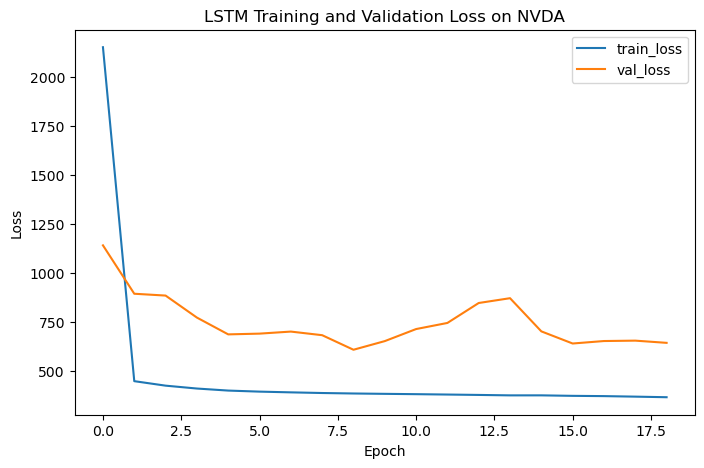

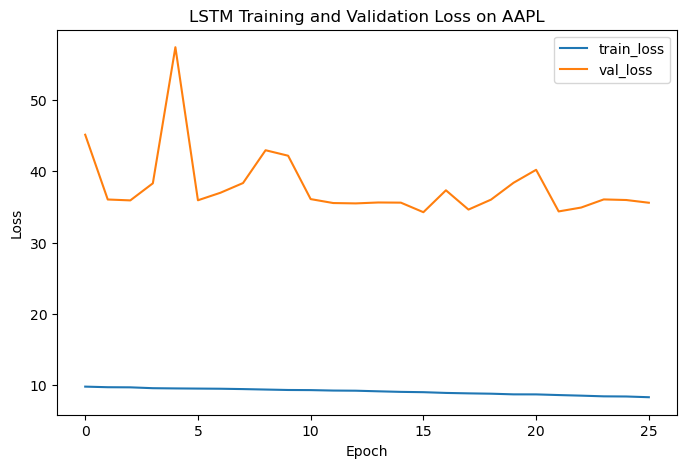

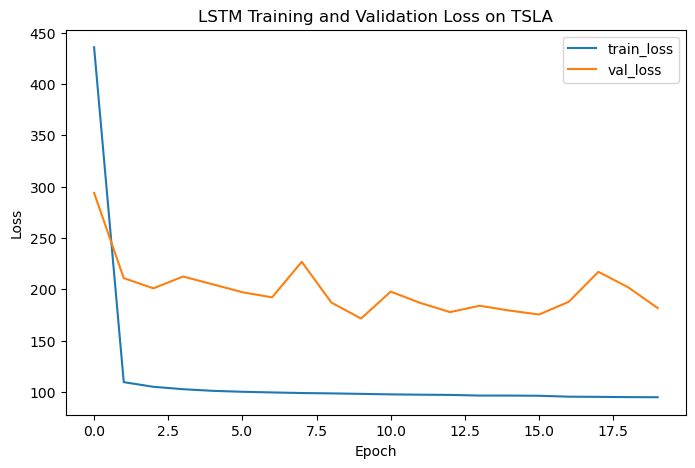

In [253]:
# Now, we can check the history object to monitor training and validation loss
# Plotting the training history can help us see the performance over epochs

def plot_history(history, title):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Plot the training history for each model
plot_history(history_lstm_tuned_NVDA, 'LSTM Training and Validation Loss on NVDA')
plot_history(history_lstm_tuned, 'LSTM Training and Validation Loss on AAPL')
plot_history(history_lstm_tuned_TSLA, 'LSTM Training and Validation Loss on TSLA')